<h1> DeepLearning Final Report </h1>

Seo, GiTae <br>
Department of Statistics, Chung-Ang University <br>
June 21, 2021 <br>

1. 주제 <br>

    : GAN(Generative adversarial networks)을 이용한 제조 공정 데이터의 데이터 불균형(Data Imbalance) 문제 해결. <br>
<br>
<br>
2. 요약 <br>

    제조 공정 데이터의 경우 클래스 불균형 문제가 빈번하게 발생한다. 가령, 제조 공정이 적절하게 배치된 경우, 결함이 존재하는 제품이 만들어질 가능성은 현저히 적다. 이러한 클래스 불균형이 존재하는 데이터를 가지고 기계학습이나 딥러닝을 적용할 경우, 모델의 신뢰성을 떨어뜨리는 문제를 발생시킨다. 본 개인과제에서는 이러한 문제를 해결하고자 GAN(Generative adversarial networks)를 이용해 소스 클래스(Minority class)에 대한 데이터를 생성하는 방법을 시도해본다. 또한, GAN을 이용해 만들어진 소수 클래스 데이터가 원본 데이터와 얼마나 유사한지를 확인하기 위하여, t-SNE를 통한 시각화를 수행한다. <br> 
<br>
3. 활용 데이터 <br>

    - 데이터: UC Irvine Machine Learning Repository, SECOM Data. <br>
    - 문제점: 합격데이터 1463개(93.3%), 불합격데이터가 104개 (6.6%)로 데이터의 불균형 존재. <br>
    - 해결책: 불균형 문제를 해결하기 위하여 본 개인과제에서는 GAN을 통한 데이터 생성 방법을 적용. <br>
<br>
<br>
4. 결론 및 시사점 <br>

    본 개인과제에서는 GAN을 이용해 제조 공정 데이터의 불균형 문제를 해결하고자 소수 클래스(= 불합격 데이터)에 대한 가짜 데이터 생성을 수행하였다. 그리고 생성된 가짜 소수 클래스 데이터가 원본 소수 클래스 데이터와 얼마나 유사한지를 확인하기 위하여, t-SNE를 통해 시각화를 수행하였다. <br>
    <br>
    개인과제 수행 과정에서 GAN의 학습 불안정 현상이 발견되었다. Visualization 파트에서 확인할 수 있듯이, Discriminator가 Generator에 비해 강하여 학습이 제대로 이루어지지 않으며, Discriminator'loss 값이 빠르게 0으로 수렴한 후, Generator's loss 값이 꾸준히 증가하는 모습을 보였다. <br>
    <br>
    또한, t-SNE를 통한 시각화를 수행하였을 때, 원본 소수 클래스 데이터와, GAN을 통해 만들어진 가짜의 소수 클래스 데이터가 정확히 구별되는 모습을 보여주었다. 따라서, GAN을 통해 만들어진 가짜의 소수 클래스 데이터가 원본 소수 클래스 데이터와 성격이 매우 다른 형태로 만들어졌다고 결론내릴 수 있다.  <br>
    <br>
    본 개인과제는 GAN의 학습과정에서 발생하는 불균형 문제를 해결하지 못했다는 점에서 한계가 있다. 그러나 GAN의 학습과정에서 발생하는 불균형 문제를 적절히 해결한다면, 원본 소수 클래스 데이터와 비슷한 성격을 가진 가짜 소수 클래스 데이터를 생성할 수 있고, 이를 이용해 학습을 수행한다면, 딥러닝 모형의 신뢰성을 높일 수 있을 것이다. <br>
<br> 
<br>
5. 개인과제를 진행하면서 든 생각들 <br>

    - 학습 불안정성을 해결하지 못한 문제도 있지만, 해결하였을 경우의 다음 과정이 실제적으로 존재하는 지에 대해 의문이 들었음.
     
      “ 만약, 학습 불안정을 해결해서 데이터를 생성했다면, 생성된 데이터 중 어떤 데이터를 사용할 것이며, 그 판단 기준은 어떻게 삼을 것인가? “

   - 위의 물음에 대한 자료들을 구글링을 통해 검색해 본 결과 공통된 의견이 대부분이었음.
 
     “ 비구조적 데이터인 이미지에 GAN을 사용한다면, 비교적 주관적이라도 눈으로 결과를 확인하여 판단이 가능하지만, 구조적 데이터에 GAN을 사용한다면, 데이터가 잘 생성되었는 지에 대한 결과를 어떻게 증명할 것인가? ”













# Import ~ Seed 선언

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import warnings
from sklearn.manifold import TSNE
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Model, Sequential
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Input
from keras.optimizers import Adam
from keras import initializers

warnings.filterwarnings("ignore")
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Keras 가 Tensorflow 를 벡엔드로 사용할 수 있도록 설정.
os.environ["KERAS_BACKEND"] = "tensorflow"

# 실험을 재현하고 동일한 결과를 얻을 수 있는지 확인하기 위해 seed 를 설정.
seed = 2021
np.random.seed(seed)
tf.set_random_seed(seed)

# Data Preprocessing

## 데이터셋 불러오기

In [3]:
# 데이터셋 로드.
# delim_whitespace = True : 빈 공간(' ')을 구분자로 인식하고 데이터 읽어옴.
# squeeze 만약 컬럼 하나만 읽어오면 데이터 구조를 Series로 읽어옴.
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data"
secom = pd.read_csv(url, header=None, delim_whitespace=True)
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data"
y = pd.read_csv(url, header=None, usecols=[0], squeeze=True, delim_whitespace=True) 

In [4]:
print(type(secom)) # 데이터 구조: DataFrame.
print(secom.shape) # 1567개의 인스턴스 590개의 속성.
secom.head()

<class 'pandas.core.frame.DataFrame'>
(1567, 590)


,0,1,2,3,4,5,6,7,8,9,...,580,581,582,583,584,585,586,587,588,589
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


## 데이터셋 파악

In [5]:
print('The dataset has {} observations/rows and {} variables/columns.'.format(secom.shape[0], secom.shape[1]))
print('The majority class has {} observations, minority class {}.'.format(y[y == -1].size, y[y == 1].size))
print('The dataset is imbalanced. The ratio of majority class to minority class is {%.2f}:1.' % (float(y[y == -1].size/y[y == 1].size)))

The dataset has 1567 observations/rows and 590 variables/columns.
The majority class has 1463 observations, minority class 104.
The dataset is imbalanced. The ratio of majority class to minority class is {14.07}:1.


In [6]:
# 결측치를 가지고 있는 컬럼이 몇 개 인지 확인하는 코드.

nmv = secom.dropna(axis=1) # 열을 기준으로 NaN 값이 존재하면 그 열을 삭제하고 반환.
print('No. of columns after removing columns with missing data: {}'.format(nmv.shape[1]))

nmv = secom.dropna(axis=0) # 행을 기준으로 NaN 값이 존재하면 그 열을 삭제하고 반환.
print('No. of rows after removing rows with missing data: {}'.format(nmv.shape[0]))

del nmv # nmv 변수는 확인 후 바로 삭제.

No. of columns after removing columns with missing data: 52
No. of rows after removing rows with missing data: 0


## 상수 값을 가지는 열 제거

In [7]:
# 상수 값을 가지는 열을 제거하기 위한 코드. 

dropthese = [i for i in range(590) if secom[i].std() == 0]
secom_categorical = secom.drop(dropthese, axis = 1)
print(secom_categorical.shape)
secom_categorical.head()

print('There are {} columns which have identical values recorded.'.format(len(dropthese)))
print('The data set now has {} columns.'.format(secom_categorical.shape[1]))

(1567, 474)
There are 116 columns which have identical values recorded.
The data set now has 474 columns.


## 결측치 확인 

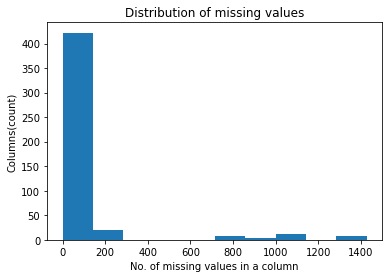

In [8]:
# 결측치 파악을 위한 히스토그램 출력.

secom_categorical = pd.DataFrame(secom_categorical)
feature_names = secom_categorical.columns

m = list((map(lambda i: sum(secom_categorical[i].isnull()), feature_names)))
plt.hist(m)
plt.title("Distribution of missing values")
plt.xlabel("No. of missing values in a column")
plt.ylabel("Columns(count)")
plt.show()

In [9]:
# 결측치 파악을 위한 문구 출력.

criteria_list = [100, 200, 400, 500, 600, 700, 800, 900, 1000]

for criteria in criteria_list :
    columns_filtered = list(filter(lambda i: sum(secom_categorical[i].isnull()) > criteria, secom_categorical.columns))
    print('The number of columns with more than {:>4d} missing values(about {}%): {:>2d}'.format(criteria, int((criteria/1253)*100), len(columns_filtered)))

The number of columns with more than  100 missing values(about 7%): 52
The number of columns with more than  200 missing values(about 15%): 52
The number of columns with more than  400 missing values(about 31%): 32
The number of columns with more than  500 missing values(about 39%): 32
The number of columns with more than  600 missing values(about 47%): 32
The number of columns with more than  700 missing values(about 55%): 32
The number of columns with more than  800 missing values(about 63%): 24
The number of columns with more than  900 missing values(about 71%): 24
The number of columns with more than 1000 missing values(about 79%): 20


## 결측치 제거 

In [10]:
# 결측치가 criteria(=200)을 초과하는 열을 추출해내는 함수.

def get_columns_over_200NaN(df) :
    criteria = 200
    filtered_columns = list(filter(lambda i: sum(df[i].isnull()) > criteria, df.columns))
    return filtered_columns

# main
filtered_columns = get_columns_over_200NaN(secom_categorical)
secom_categorical = secom_categorical.drop(filtered_columns, 1)

print(secom_categorical.shape)
secom_categorical.head()

(1567, 422)


,0,1,2,3,4,6,7,8,9,10,...,576,577,582,583,584,585,586,587,588,589
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,97.6133,0.1242,1.5005,0.0162,-0.0034,...,1.6765,14.9509,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,102.3433,0.1247,1.4966,-0.0005,-0.0148,...,1.1065,10.9003,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,95.4878,0.1241,1.4436,0.0041,0.0013,...,2.0952,9.2721,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,104.2367,0.1217,1.4882,-0.0124,-0.0033,...,1.7585,8.5831,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.3967,0.1235,1.5031,-0.0031,-0.0072,...,1.6597,10.9698,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


## 데이터셋 분리

In [11]:
# train / test split을 수행.
from sklearn.model_selection import train_test_split

# 소수 클래스를 train set : test set = 4 : 1로 들어가도록 하기 위해서 stratify 옵션 추가.
X_train, X_test, y_train, y_test = train_test_split(secom_categorical, y, test_size = 0.2, stratify = y) 

In [12]:
# ndarray 
print(X_train.shape) # (1253, 422)
print(X_test.shape) # (314, 422)
print(y_train.shape) # (1253,)
print(y_test.shape) # (314,)

(1253, 422)
(314, 422)
(1253,)
(314,)


## 결측치 재확인

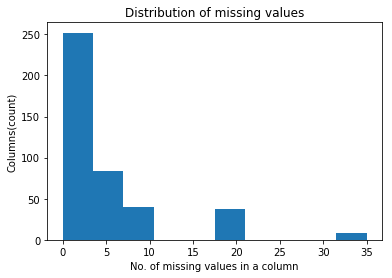

In [13]:
# 결측치 파악을 위한 히스토그램 출력.
df_X_train = pd.DataFrame(X_train)
feature_names = df_X_train.columns

m = list((map(lambda i: sum(df_X_train[i].isnull()), feature_names)))
plt.hist(m)
plt.title("Distribution of missing values")
plt.xlabel("No. of missing values in a column")
plt.ylabel("Columns(count)")
plt.show()

## 결측치 채우기 (by Gaussian Distribution)

In [14]:
# fill_NaN_by_Gaussian 함수를 적용하기 위해 데이터 형변환 (ndarray -> DataFrame).
df_X_train = pd.DataFrame(X_train)
df_X_test = pd.DataFrame(X_test)
print(df_X_train.shape)
print(df_X_test.shape)

(1253, 422)
(314, 422)


In [15]:
def fill_NaN_by_Gaussian(df_X_train, df_X_test) :
      
    """결측치를 해당 열의 가우시안 분포를 따르는 난수로 대체하는 함수이다.
       단, test셋의 각 열은 train셋의 각 열의 가우시안 분포를 따른다고 가정한다.
       따라서, test셋은 train셋의 mean, std를 사용한다.                      """
    
    for column in df_X_train.columns.values : 
        
        mean = df_X_train[column].mean()
        std = df_X_train[column].std()
            
        X_train_NaN_size = sum(df_X_train[column].isnull())
        X_test_NaN_size = sum(df_X_test[column].isnull())
          
        df_X_train.loc[df_X_train[column].isnull(), column] = np.random.normal(mean, std, size = X_train_NaN_size)            
        df_X_test.loc[df_X_test[column].isnull(), column] = np.random.normal(mean, std, size = X_test_NaN_size)

    return (df_X_train, df_X_test)
                          
                          
# main
df_X_train, df_X_test = fill_NaN_by_Gaussian(df_X_train, df_X_test)
print(df_X_train.shape)       
print(df_X_test.shape)

(1253, 422)
(314, 422)


In [16]:
# 결측치를 채우고 난 후 정상적으로 결측치가 채워졌는지 재확인하는 코드.

# df_X_train
nmv = df_X_train.dropna(axis=1) # 열을 기준으로 NaN 값이 존재하면 그 열을 삭제하고 반환.
print('No. of columns after removing columns with missing data: {}'.format(nmv.shape[1]))

nmv = df_X_train.dropna(axis=0) # 행을 기준으로 NaN 값이 존재하면 그 열을 삭제하고 반환.
print('No. of rows after removing rows with missing data: {}'.format(nmv.shape[0]))

del nmv  # nmv 변수는 확인 후 바로 삭제

# df_X_test
nmv = df_X_test.dropna(axis=1) # 열을 기준으로 NaN 값이 존재하면 그 열을 삭제하고 반환.
print('No. of columns after removing columns with missing data: {}'.format(nmv.shape[1]))

nmv = df_X_test.dropna(axis=0) # 행을 기준으로 NaN 값이 존재하면 그 열을 삭제하고 반환.
print('No. of rows after removing rows with missing data: {}'.format(nmv.shape[0]))

del nmv  # nmv 변수는 확인 후 바로 삭제

No. of columns after removing columns with missing data: 422
No. of rows after removing rows with missing data: 1253
No. of columns after removing columns with missing data: 422
No. of rows after removing rows with missing data: 314


## Min-Max Scaling

In [17]:
# Min-Max Scaling feature_range = (-1, 1).
# (0, 1)로 하지 않는 이유는 Generator가 출력층 함수로 tanh를 사용하기 때문임.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

mm_scale_parameters = scaler.fit(df_X_train.values) 

scaled_X_train= mm_scale_parameters.transform(df_X_train) 
scaled_X_test= mm_scale_parameters.transform(df_X_test) 

scaled_df_X_train = pd.DataFrame(scaled_X_train, index = df_X_train.index, columns = df_X_train.columns) # 데이터 프레임으로 변환, 기존의 index, columns 사용.
scaled_df_X_test = pd.DataFrame(scaled_X_test, index =df_X_test.index, columns = df_X_test.columns) # 데이터 프레임으로 변환, 기존의 index, columns 사용.

In [18]:
print(scaled_df_X_train.shape)
scaled_df_X_train.head()  

(1253, 422)


,0,1,2,3,4,6,7,8,9,10,...,576,577,582,583,584,585,586,587,588,589
413,0.068658,0.098402,0.202605,-0.384729,-0.883071,-0.064725,0.777129,0.363128,-0.320229,-0.214586,...,-0.981422,-0.774622,0.63750,-0.946786,-0.947471,-0.832116,-0.475355,-0.528031,-0.536232,-0.602571
539,-0.118935,-0.064491,0.255409,-0.153697,-0.881290,0.084631,0.832893,0.540610,-0.521704,-0.632539,...,-0.980499,-0.626959,0.45625,-0.963814,-0.957198,-0.847086,-0.737678,-0.426336,-0.485507,-1.000000
303,-0.592013,-0.187909,0.397327,-0.083281,-0.882768,-0.270862,0.766856,0.493769,-0.374283,0.138850,...,-0.961725,-0.940155,0.66875,-0.975734,-0.972763,-0.858161,-0.405180,-0.801825,-0.833333,-0.842446
206,-0.221128,0.164246,-0.024151,-0.456969,-0.882580,-0.107215,0.827023,-0.130640,-0.601966,-0.405330,...,-0.990157,-0.893438,0.33125,-0.994891,-0.988327,-0.874927,-0.512114,-0.838331,-0.884058,-0.792600
1540,-0.229832,0.155084,0.022020,0.950547,-0.882936,-0.925910,0.832893,-0.033949,-0.274365,-0.021038,...,-0.970599,-0.551972,0.45625,-0.959557,-0.964981,-0.843190,-0.415205,-0.762712,-0.739130,-0.816446


In [19]:
print(scaled_df_X_test.shape)
scaled_df_X_test.head()

(314, 422)


,0,1,2,3,4,6,7,8,9,10,...,576,577,582,583,584,585,586,587,588,589
155,-0.036027,0.066120,-0.013328,-0.398445,-0.882140,-0.090335,0.778596,0.281049,-0.238329,-0.267882,...,-0.976088,-0.832198,0.40625,-0.965092,-0.949416,-0.848241,-0.336675,-0.303781,-0.311594,-0.643962
301,-0.037358,-0.046867,0.106944,-0.460470,-0.882993,-0.241762,0.763921,-0.565535,-0.403767,-0.077139,...,-0.979925,-0.874425,0.54375,-0.966369,-0.964981,-0.849609,-0.403509,-0.736636,-0.753623,-0.808603
1098,0.030941,-0.129433,-0.069537,-0.278497,-0.882919,-0.092882,0.765389,-0.171895,-0.187551,-0.093969,...,-0.990095,-0.733216,0.54375,-0.966369,-0.974708,-0.849640,-0.418546,-0.877445,-0.898551,-0.880322
1297,-0.193276,-0.252454,0.147966,-0.218044,-0.882638,-0.352307,0.790336,0.103137,-0.074529,0.200561,...,-0.976038,-0.968746,0.53125,-0.945509,-0.949416,-0.830880,-0.208020,-0.337679,-0.195652,-0.745558
406,-0.499309,0.047594,0.202605,-0.384729,-0.883071,-0.064725,0.777129,0.168028,0.040131,-0.761571,...,-0.979590,-0.826779,0.42500,-0.950617,-0.937743,-0.835099,-0.615706,-0.715776,-0.739130,-0.367306


## Import and Apply PCA

In [20]:
# 몇 개의 주성분을 사용해야 하는지 알아보기 위해 작성한 코드.
from sklearn.decomposition import PCA

varianceList = [0.80, 0.85, 0.9, 0.95, 0.99, 1]

for ratio in varianceList :
    pca = PCA(ratio)
    pca.fit(scaled_X_train)
    if ratio == 1 :
        print("Choose {:3d} eigenvectors which explain {}% of the variance.".format(474, (pca.n_components)*100))
    else :
        print("Choose {:3d} eigenvectors which explain {:>3d}% of the variance.".format(pca.n_components_, int(pca.n_components*100)))
    del pca 

Choose  65 eigenvectors which explain  80% of the variance.
Choose  79 eigenvectors which explain  85% of the variance.
Choose  98 eigenvectors which explain  90% of the variance.
Choose 127 eigenvectors which explain  95% of the variance.
Choose 187 eigenvectors which explain  99% of the variance.
Choose 474 eigenvectors which explain 100% of the variance.


In [21]:
# PCA 인스턴스 객체를 생성.
pca = PCA(0.8)

# 생성된 PCA 인스턴스 객체에 scaled_df_X_train를 Fitting.
# 주의: fit은 오직 scaled_df_X_train에만 적용.
# 동일한 파라미터를 scaled_df_X_test에 적용하기 위함.
pca.fit(scaled_df_X_train)

# transform하게 되면  ndarray로 반환하기 때문에 별도의 DataFrame 형변환 필요.
X_train_after_PCA = pca.transform(scaled_df_X_train)
X_test_after_PCA = pca.transform(scaled_df_X_test)

In [22]:
# PCA 수행 후의 X_train을 DataFrame으로 형변환 .
df_X_train_after_PCA = pd.DataFrame(data=X_train_after_PCA, index=scaled_df_X_train.index)
print(df_X_train_after_PCA.shape)
df_X_train_after_PCA.head()

(1253, 65)


,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
413,0.555819,0.832796,-1.085397,-0.015168,1.782033,1.468409,-0.327396,-0.570852,0.141465,-0.976581,...,-0.276464,0.183443,0.635760,-0.190264,0.129322,0.051642,0.173329,0.113681,0.005355,-0.382805
539,2.260239,-0.403487,-0.703414,-0.899181,-0.540910,0.206569,-0.325091,-0.069984,0.914217,0.076039,...,-0.130279,-0.686116,0.111956,-0.509376,-0.443845,-0.567252,-0.652665,0.437996,-0.587273,-0.113833
303,1.240178,0.963555,0.348874,-0.630317,0.468556,-0.221222,-1.029214,0.731705,-0.450841,0.253264,...,-0.158767,-0.052453,0.132449,-0.085938,0.433911,-0.364960,0.224553,0.649555,-0.179848,-0.316684
206,0.601443,1.004937,-0.053628,-1.477902,-0.047744,0.158757,0.098575,-0.492175,1.431897,0.261539,...,-0.226445,0.188888,0.240889,-0.069381,-0.874596,0.262111,0.033536,-0.077363,-0.005878,-0.180019
1540,-0.920895,0.026193,-0.589321,0.006652,0.626573,-0.560860,0.129831,0.150218,0.308505,1.305377,...,-0.012728,0.111327,-0.404631,0.131685,-0.117681,-0.208217,-0.144920,0.473772,-0.336963,-0.216163


In [23]:
# PCA 수행 후의 X_test을 DataFrame으로 형변환.
df_X_test_after_PCA = pd.DataFrame(data=X_test_after_PCA, index=scaled_df_X_test.index)
print(df_X_test_after_PCA.shape)
df_X_test_after_PCA.head()

(314, 65)


,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
155,0.344000,1.471646,0.083931,-1.005398,-0.668682,-0.609312,-0.115042,-0.052723,0.433166,0.732203,...,-0.265648,0.186460,-0.162781,0.230467,-0.436698,0.072965,0.047291,-0.076998,-0.141822,0.290496
301,1.221113,1.272723,0.221692,-1.466738,1.147357,-0.346949,-0.069541,0.659506,-1.020670,0.285798,...,-0.436955,-0.160581,0.034862,0.068015,-0.167699,0.056736,0.061689,-0.058098,0.437410,-0.349777
1098,-1.582787,-0.018922,1.776363,-0.927291,0.450600,-0.525468,-0.013949,-0.379171,-0.517423,-0.855350,...,-0.000537,0.145144,0.255012,-0.406381,-0.238083,-0.020977,0.484680,-0.294286,0.000436,-0.325111
1297,-1.022876,-0.375277,1.662799,-1.086755,1.920393,-0.313759,-0.749415,1.073322,-0.831451,-0.767988,...,-0.152669,0.266067,0.222436,-0.220656,-0.177733,0.807406,0.099284,-0.702093,0.507292,-0.175280
406,-0.162674,0.401833,-0.104211,-0.749121,0.026453,-0.301396,0.578638,-0.417815,-0.707657,-0.157134,...,0.348816,1.083277,0.580875,-0.275893,0.158424,0.028858,-0.038913,0.487862,0.026629,-0.425030


## 소수 클래스 추출

In [24]:
# 소수 클래스 데이터 프레임을 만들기 위해 y_train을 데이터 프레임으로 변환.
df_y_train = y_train.to_frame()
df_y_train.columns = [590]
print(df_y_train.shape)
df_y_train.head()

(1253, 1)


,590
413,-1
539,-1
303,-1
206,-1
1540,-1


In [25]:
# df_train_after_preprocessing: 전처리가 끝난 train data.
df_train_after_preprocessing = df_X_train_after_PCA.join(df_y_train, how ='left')
print(df_train_after_preprocessing.shape)
df_train_after_preprocessing.head()

(1253, 66)


,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,590
413,0.555819,0.832796,-1.085397,-0.015168,1.782033,1.468409,-0.327396,-0.570852,0.141465,-0.976581,...,0.183443,0.635760,-0.190264,0.129322,0.051642,0.173329,0.113681,0.005355,-0.382805,-1
539,2.260239,-0.403487,-0.703414,-0.899181,-0.540910,0.206569,-0.325091,-0.069984,0.914217,0.076039,...,-0.686116,0.111956,-0.509376,-0.443845,-0.567252,-0.652665,0.437996,-0.587273,-0.113833,-1
303,1.240178,0.963555,0.348874,-0.630317,0.468556,-0.221222,-1.029214,0.731705,-0.450841,0.253264,...,-0.052453,0.132449,-0.085938,0.433911,-0.364960,0.224553,0.649555,-0.179848,-0.316684,-1
206,0.601443,1.004937,-0.053628,-1.477902,-0.047744,0.158757,0.098575,-0.492175,1.431897,0.261539,...,0.188888,0.240889,-0.069381,-0.874596,0.262111,0.033536,-0.077363,-0.005878,-0.180019,-1
1540,-0.920895,0.026193,-0.589321,0.006652,0.626573,-0.560860,0.129831,0.150218,0.308505,1.305377,...,0.111327,-0.404631,0.131685,-0.117681,-0.208217,-0.144920,0.473772,-0.336963,-0.216163,-1


In [26]:
# df_train_after_preprocessing에서 소수 클래스만 추출하여 데이터 프레임화.
df_minority_class = df_train_after_preprocessing.loc[df_train_after_preprocessing[590]==1]
print(df_minority_class.shape)
df_minority_class.head()

(83, 66)


,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,590
241,0.002669,1.096903,0.187869,-0.767243,0.355404,0.391799,-0.093173,0.138923,0.219974,-1.573464,...,0.000020,-0.145016,0.479690,0.124005,-0.049169,-0.070657,-0.032557,-0.219620,-0.372249,1
273,1.018734,0.472750,0.681980,-0.696233,1.123876,0.908436,-0.841071,0.455408,0.941914,0.708525,...,-0.251688,0.382136,0.235736,-0.421011,0.938741,0.511132,-0.242863,0.750031,0.316338,1
926,-0.977358,1.453769,-0.232678,0.154169,-1.288769,-0.460426,0.438308,0.100593,-1.042581,-0.274904,...,-0.600389,-0.339776,-0.400525,0.862997,0.558220,-0.319688,0.346913,0.472857,-0.732237,1
1365,0.626939,-0.742570,-0.832898,-0.479723,1.147157,-0.452925,0.481591,0.237545,0.187599,0.526429,...,-0.162749,0.066120,0.183428,-0.183547,-0.064892,-0.124131,-0.386813,0.145367,0.233323,1
96,2.922847,0.790853,4.073752,2.639991,0.654930,-1.457540,1.051435,0.091853,1.484751,0.056681,...,0.512540,-0.229040,0.007257,0.010430,-0.368255,-0.273900,-0.026258,-0.028630,-0.065556,1


## 중간 정리 (변수)

(secom, y): 세콤 데이터셋을 처음 불러올 때 

secom_categorical: secom에서 상수값을 제거, 결측치가 200개 초과인 열 제거

(X_train, X_test, y_train, y_test): secom_categorical과 y를 훈련셋과 테스트셋으로 8:2로 분리

df_X_train: X_train을 데이터 프레임으로 변환 후 결측치를 가우시안 분포를 따르는 난수로 채움 

df_X_test: X_test을 데이터 프레임으로 변환 후 결측치를 가우시안 분포를 따르는 난수로 채움

scaled_df_X_train: df_X_train에서 Min-Max Sacling 수행

scaled_df_X_test: df_X_test에서 Min-Max Sacling 수행

df_y_train: y_train을 데이터 프레임으로 변환

df_train_after_preprocessing: scaled_df_X_train + df_y_train 

df_minority_class: df_train_after_preprocessing에서 소수 클래스만 추출하여 데이터 프레임으로 변환

# GAN (Generative adversarial networks)

In [27]:
# 랜덤 노이즈 벡터의 차원을 설정.
# 랜덤 노이즈 벡터는 50 ~ 특성*2 사이 숫자로 설정.
random_dim = 100

In [28]:
# (83, 65), 65는 레이블 열이 포함된 것.
# 10차원의 latent vector z를 통해 64개의 속성을 나타내야 함.
print(df_minority_class.shape) 
df_minority_class.head()

(83, 66)


,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,590
241,0.002669,1.096903,0.187869,-0.767243,0.355404,0.391799,-0.093173,0.138923,0.219974,-1.573464,...,0.000020,-0.145016,0.479690,0.124005,-0.049169,-0.070657,-0.032557,-0.219620,-0.372249,1
273,1.018734,0.472750,0.681980,-0.696233,1.123876,0.908436,-0.841071,0.455408,0.941914,0.708525,...,-0.251688,0.382136,0.235736,-0.421011,0.938741,0.511132,-0.242863,0.750031,0.316338,1
926,-0.977358,1.453769,-0.232678,0.154169,-1.288769,-0.460426,0.438308,0.100593,-1.042581,-0.274904,...,-0.600389,-0.339776,-0.400525,0.862997,0.558220,-0.319688,0.346913,0.472857,-0.732237,1
1365,0.626939,-0.742570,-0.832898,-0.479723,1.147157,-0.452925,0.481591,0.237545,0.187599,0.526429,...,-0.162749,0.066120,0.183428,-0.183547,-0.064892,-0.124131,-0.386813,0.145367,0.233323,1
96,2.922847,0.790853,4.073752,2.639991,0.654930,-1.457540,1.051435,0.091853,1.484751,0.056681,...,0.512540,-0.229040,0.007257,0.010430,-0.368255,-0.273900,-0.026258,-0.028630,-0.065556,1


## 데이터셋 불러오기

In [29]:
# df_minority_class에서 레이블 열을 제외하고 특성치의 값들만 가져옴.
x_train = df_minority_class.values[: , 0:-1]
x_train

array([[ 0.00266878,  1.09690282,  0.18786894, ..., -0.03255685,
        -0.21961957, -0.3722487 ],
       [ 1.0187343 ,  0.4727497 ,  0.68198024, ..., -0.24286284,
         0.75003112,  0.31633832],
       [-0.97735844,  1.45376922, -0.23267815, ...,  0.34691262,
         0.47285666, -0.73223665],
       ...,
       [-0.14875676,  1.18207226, -0.43678241, ..., -0.35328534,
        -0.14142692,  0.20092678],
       [-1.56284676,  1.61257455,  0.08611474, ..., -0.02402743,
         0.2235307 ,  0.37741977],
       [ 0.59080184, -1.42210139, -0.0723355 , ...,  0.11189285,
        -0.19597705,  0.63227921]])

## Optimizer 정의

In [30]:
# Discriminator가 Generator에 비해 강하기 때문에 Adam Optimizer 학습률을 통해 조정.
# D,G의 loss, acc는 Optimizer의 learning rate에 영향을 크게 받는다는 것을 확인.
g_optimizer = Adam(lr=0.0002, beta_1=0.5) 
d_optimizer = Adam(lr=0.00002, beta_1=0.5)

Instructions for updating:
Colocations handled automatically by placer.


## Generator / Discriminator 정의

In [31]:
# Generator 정의.
generator_ = Sequential()

generator_.add(Dense(125, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator_.add(LeakyReLU(0.2))
    
generator_.add(Dense(250))
generator_.add(LeakyReLU(0.2))
    
generator_.add(Dense(125))
generator_.add(LeakyReLU(0.2))
    
generator_.add(Dense(x_train.shape[1], activation='tanh')) # x_train.shape[1] = 64
    
# DIscriminator 정의.
discriminator_ = Sequential()

discriminator_.add(Dense(125, input_dim=x_train.shape[1], kernel_initializer=initializers.RandomNormal(stddev=0.02))) # x_train.shape[1] = 64
discriminator_.add(LeakyReLU(0.2))
discriminator_.add(Dropout(0.3))

discriminator_.add(Dense(250))
discriminator_.add(LeakyReLU(0.2))
discriminator_.add(Dropout(0.3))

discriminator_.add(Dense(125))
discriminator_.add(LeakyReLU(0.2))
discriminator_.add(Dropout(0.3))

discriminator_.add(Dense(1, activation='sigmoid'))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [32]:
# Sequential object for Generator.
noise_input = Input(shape=(random_dim,)) 
generator_output = generator_(noise_input)
generator = Model(inputs = noise_input, outputs = generator_output)
generator.compile(loss="binary_crossentropy", optimizer=g_optimizer, metrics=['binary_accuracy'])

# Sequential object for Discriminator.
discriminator_input = Input(shape=(x_train.shape[1],))
discriminator_output = discriminator_(discriminator_input)
discriminator = Model(inputs = discriminator_input, outputs = discriminator_output)
discriminator.compile(loss='binary_crossentropy', optimizer=d_optimizer, metrics=['binary_accuracy'])

# 중간 확인 코드.
print(generator_)
print(discriminator_)
print(generator)
print(discriminator)

In [33]:
# Generator model summary.
generator_.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 125)               12625     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 125)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 250)               31500     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 250)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 125)               31375     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 125)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 65)                8190      
Total para

In [34]:
# Discriminator model summary.
discriminator_.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 125)               8250      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 125)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 125)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 250)               31500     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 250)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 125)               31375     
__________

In [35]:
# Generator model summary.
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 65)                83690     
Total params: 83,690
Trainable params: 83,690
Non-trainable params: 0
_________________________________________________________________


In [36]:
# Generator model summary.
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 65)                0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 71251     
Total params: 71,251
Trainable params: 71,251
Non-trainable params: 0
_________________________________________________________________


## Generator / Discriminator 통합

In [37]:
# GAN 정의.
# Generator 학습 중에 Discriminator 가중치 업데이트가 발생하지 않도록 설정.
discriminator.trainable = False
    
gan_input = Input(shape=(random_dim,))    
generator_output = generator(gan_input) 
gan_output = discriminator(generator_output)
    
gan = Model(inputs=gan_input, outputs=gan_output)
gan.compile(loss="binary_crossentropy", optimizer=g_optimizer, metrics=['binary_accuracy'])

In [38]:
# GAN model summary.
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_1 (Model)              (None, 65)                83690     
_________________________________________________________________
model_2 (Model)              (None, 1)                 71251     
Total params: 154,941
Trainable params: 83,690
Non-trainable params: 71,251
_________________________________________________________________


In [39]:
# RECAP CODE.
print(generator_)
print(discriminator_)
print(generator)
print(discriminator)
print(gan)

## 생성된 데이터를 출력해주는 함수 

In [40]:
# Generator로부터 생성된 Data를 보여주는 함수.
def get_generated_data(epoch, generator, examples=100) : # examples 기본값 100 설정, examples: generator가 만들어 내는 가상 데이터의 개수
    
    noise = np.random.normal(0, 1, size = [examples, random_dim])  
    generated_data = generator.predict(noise) # ndarray 
    generated_data = pd.DataFrame(data = generated_data, columns=df_X_test_after_PCA.columns)
    generated_data.to_csv(path_or_buf="../../mypydata/generatedData/gan_generated_data_epoch_%d.csv" % epoch, index = False)

    return generated_data # ndarray

## Train / Fit  정의

In [41]:
smooth = 0 # Discriminator가 너무 강하다면 0.1 ~ 0.2 정도로 설정하고 사용.

def train(epochs=5000, print_step=10):
    
    # 히스토그램 출력하기 위해 전역 변수 선언함.
    global d_loss_real_list, d_loss_fake_list, g_loss_list, d_acc_real_list, d_acc_fake_list, g_acc_list
    
    d_loss_real_list = [] 
    d_loss_fake_list = []
    g_loss_list = []
    d_acc_real_list = []
    d_acc_fake_list = []
    g_acc_list = []
    
    for e in range(1, epochs+1) : 
               
        # Discriminator 학습.
        discriminator.trainable = True
        
        # real data 학습.
        real_data = x_train
        y_dis_real = np.ones(shape=(x_train.shape[0], 1)) - smooth 
        d_loss_real = discriminator.train_on_batch(real_data, y_dis_real)
    
        # fake data 학습.
        noise = np.random.normal(0, 1, size = [x_train.shape[0], random_dim])  
        generated_data= generator.predict_on_batch(noise)   
        y_dis_generated = np.zeros(shape=(x_train.shape[0], 1)) + smooth 
        d_loss_fake = discriminator.train_on_batch(generated_data, y_dis_generated)
            
        # Generator 학습.
        discriminator.trainable = False
        
        noise = np.random.normal(0, 1, size = [x_train.shape[0], random_dim])  
        y_gen = np.ones(shape=(x_train.shape[0], 1)) 
        g_loss = gan.train_on_batch(noise, y_gen)
    
        # 학습과정 기록.
        d_loss_real_list.append(d_loss_real[0])
        d_loss_fake_list.append(d_loss_fake[0])
        d_acc_real_list.append(d_loss_real[1])
        d_acc_fake_list.append(d_loss_fake[1])
        g_loss_list.append(g_loss[0])
        g_acc_list.append(g_loss[1])
    
        # 기록 문구 출력.
        if (e == 1) or (e % print_step == 0) :
            record = (e, d_loss_real[0], d_loss_real[1]*100, d_loss_fake[0], d_loss_fake[1]*100, g_loss[0], g_loss[1]*100)
            print("%4d [D(real) loss: %.3f, acc: %.2f%%]  [D(fake) loss: %.3f, acc: %.2f%%]  [G loss: %.3f, acc: %.2f%%]" % record)
        
        # 생성 데이터를 CSV 파일로 저장.
        if (e == 1) or (e % print_step == 0) :
            generated_data = get_generated_data(e, generator, examples=x_train.shape[0]) 

## 학습 수행

In [42]:
# train 수행 및 로그 출력.
train(5000, 10)

Instructions for updating:
Use tf.cast instead.
   1 [D(real) loss: 0.687, acc: 60.24%]  [D(fake) loss: 0.694, acc: 40.96%]  [G loss: 0.693, acc: 51.81%]
  10 [D(real) loss: 0.682, acc: 62.65%]  [D(fake) loss: 0.701, acc: 9.64%]  [G loss: 0.685, acc: 95.18%]
  20 [D(real) loss: 0.676, acc: 68.67%]  [D(fake) loss: 0.714, acc: 1.20%]  [G loss: 0.672, acc: 98.80%]
  30 [D(real) loss: 0.670, acc: 75.90%]  [D(fake) loss: 0.731, acc: 0.00%]  [G loss: 0.658, acc: 98.80%]
  40 [D(real) loss: 0.660, acc: 84.34%]  [D(fake) loss: 0.742, acc: 1.20%]  [G loss: 0.650, acc: 96.39%]
  50 [D(real) loss: 0.658, acc: 84.34%]  [D(fake) loss: 0.736, acc: 4.82%]  [G loss: 0.658, acc: 93.98%]
  60 [D(real) loss: 0.659, acc: 85.54%]  [D(fake) loss: 0.713, acc: 28.92%]  [G loss: 0.668, acc: 87.95%]
  70 [D(real) loss: 0.654, acc: 92.77%]  [D(fake) loss: 0.702, acc: 39.76%]  [G loss: 0.688, acc: 54.22%]
  80 [D(real) loss: 0.648, acc: 92.77%]  [D(fake) loss: 0.700, acc: 36.14%]  [G loss: 0.686, acc: 62.65%]
  9

 760 [D(real) loss: 0.718, acc: 20.48%]  [D(fake) loss: 0.639, acc: 93.98%]  [G loss: 0.756, acc: 2.41%]
 770 [D(real) loss: 0.714, acc: 27.71%]  [D(fake) loss: 0.641, acc: 91.57%]  [G loss: 0.747, acc: 2.41%]
 780 [D(real) loss: 0.716, acc: 20.48%]  [D(fake) loss: 0.652, acc: 96.39%]  [G loss: 0.734, acc: 7.23%]
 790 [D(real) loss: 0.705, acc: 33.73%]  [D(fake) loss: 0.667, acc: 87.95%]  [G loss: 0.726, acc: 9.64%]
 800 [D(real) loss: 0.717, acc: 21.69%]  [D(fake) loss: 0.680, acc: 63.86%]  [G loss: 0.714, acc: 21.69%]
 810 [D(real) loss: 0.713, acc: 33.73%]  [D(fake) loss: 0.685, acc: 50.60%]  [G loss: 0.707, acc: 30.12%]
 820 [D(real) loss: 0.717, acc: 28.92%]  [D(fake) loss: 0.688, acc: 50.60%]  [G loss: 0.690, acc: 62.65%]
 830 [D(real) loss: 0.712, acc: 31.33%]  [D(fake) loss: 0.702, acc: 37.35%]  [G loss: 0.690, acc: 62.65%]
 840 [D(real) loss: 0.713, acc: 28.92%]  [D(fake) loss: 0.697, acc: 39.76%]  [G loss: 0.698, acc: 49.40%]
 850 [D(real) loss: 0.710, acc: 27.71%]  [D(fake) 

1550 [D(real) loss: 0.677, acc: 67.47%]  [D(fake) loss: 0.711, acc: 43.37%]  [G loss: 0.685, acc: 53.01%]
1560 [D(real) loss: 0.669, acc: 63.86%]  [D(fake) loss: 0.716, acc: 33.73%]  [G loss: 0.671, acc: 62.65%]
1570 [D(real) loss: 0.674, acc: 63.86%]  [D(fake) loss: 0.770, acc: 3.61%]  [G loss: 0.626, acc: 96.39%]
1580 [D(real) loss: 0.669, acc: 68.67%]  [D(fake) loss: 0.760, acc: 7.23%]  [G loss: 0.631, acc: 91.57%]
1590 [D(real) loss: 0.674, acc: 66.27%]  [D(fake) loss: 0.730, acc: 20.48%]  [G loss: 0.662, acc: 69.88%]
1600 [D(real) loss: 0.671, acc: 74.70%]  [D(fake) loss: 0.714, acc: 32.53%]  [G loss: 0.679, acc: 61.45%]
1610 [D(real) loss: 0.676, acc: 68.67%]  [D(fake) loss: 0.695, acc: 50.60%]  [G loss: 0.696, acc: 53.01%]
1620 [D(real) loss: 0.674, acc: 65.06%]  [D(fake) loss: 0.676, acc: 63.86%]  [G loss: 0.721, acc: 18.07%]
1630 [D(real) loss: 0.682, acc: 61.45%]  [D(fake) loss: 0.656, acc: 78.31%]  [G loss: 0.746, acc: 18.07%]
1640 [D(real) loss: 0.687, acc: 55.42%]  [D(fake

2330 [D(real) loss: 0.663, acc: 60.24%]  [D(fake) loss: 0.708, acc: 37.35%]  [G loss: 0.672, acc: 67.47%]
2340 [D(real) loss: 0.672, acc: 63.86%]  [D(fake) loss: 0.706, acc: 38.55%]  [G loss: 0.675, acc: 63.86%]
2350 [D(real) loss: 0.678, acc: 55.42%]  [D(fake) loss: 0.726, acc: 21.69%]  [G loss: 0.675, acc: 71.08%]
2360 [D(real) loss: 0.668, acc: 63.86%]  [D(fake) loss: 0.727, acc: 26.51%]  [G loss: 0.661, acc: 75.90%]
2370 [D(real) loss: 0.673, acc: 62.65%]  [D(fake) loss: 0.727, acc: 26.51%]  [G loss: 0.659, acc: 79.52%]
2380 [D(real) loss: 0.679, acc: 53.01%]  [D(fake) loss: 0.718, acc: 30.12%]  [G loss: 0.677, acc: 59.04%]
2390 [D(real) loss: 0.680, acc: 61.45%]  [D(fake) loss: 0.706, acc: 39.76%]  [G loss: 0.683, acc: 62.65%]
2400 [D(real) loss: 0.683, acc: 57.83%]  [D(fake) loss: 0.694, acc: 51.81%]  [G loss: 0.706, acc: 38.55%]
2410 [D(real) loss: 0.679, acc: 66.27%]  [D(fake) loss: 0.674, acc: 63.86%]  [G loss: 0.722, acc: 26.51%]
2420 [D(real) loss: 0.693, acc: 54.22%]  [D(fa

3110 [D(real) loss: 0.665, acc: 71.08%]  [D(fake) loss: 0.718, acc: 22.89%]  [G loss: 0.679, acc: 71.08%]
3120 [D(real) loss: 0.661, acc: 74.70%]  [D(fake) loss: 0.706, acc: 33.73%]  [G loss: 0.676, acc: 78.31%]
3130 [D(real) loss: 0.666, acc: 74.70%]  [D(fake) loss: 0.704, acc: 34.94%]  [G loss: 0.689, acc: 60.24%]
3140 [D(real) loss: 0.655, acc: 78.31%]  [D(fake) loss: 0.703, acc: 36.14%]  [G loss: 0.689, acc: 60.24%]
3150 [D(real) loss: 0.667, acc: 66.27%]  [D(fake) loss: 0.704, acc: 24.10%]  [G loss: 0.694, acc: 51.81%]
3160 [D(real) loss: 0.646, acc: 69.88%]  [D(fake) loss: 0.692, acc: 49.40%]  [G loss: 0.704, acc: 37.35%]
3170 [D(real) loss: 0.649, acc: 79.52%]  [D(fake) loss: 0.681, acc: 63.86%]  [G loss: 0.719, acc: 28.92%]
3180 [D(real) loss: 0.655, acc: 69.88%]  [D(fake) loss: 0.676, acc: 68.67%]  [G loss: 0.709, acc: 26.51%]
3190 [D(real) loss: 0.649, acc: 71.08%]  [D(fake) loss: 0.671, acc: 71.08%]  [G loss: 0.710, acc: 28.92%]
3200 [D(real) loss: 0.650, acc: 73.49%]  [D(fa

3880 [D(real) loss: 0.654, acc: 72.29%]  [D(fake) loss: 0.709, acc: 48.19%]  [G loss: 0.693, acc: 46.99%]
3890 [D(real) loss: 0.656, acc: 68.67%]  [D(fake) loss: 0.696, acc: 56.63%]  [G loss: 0.707, acc: 33.73%]
3900 [D(real) loss: 0.663, acc: 63.86%]  [D(fake) loss: 0.708, acc: 43.37%]  [G loss: 0.675, acc: 61.45%]
3910 [D(real) loss: 0.667, acc: 69.88%]  [D(fake) loss: 0.744, acc: 24.10%]  [G loss: 0.657, acc: 71.08%]
3920 [D(real) loss: 0.658, acc: 63.86%]  [D(fake) loss: 0.713, acc: 39.76%]  [G loss: 0.670, acc: 59.04%]
3930 [D(real) loss: 0.659, acc: 65.06%]  [D(fake) loss: 0.684, acc: 61.45%]  [G loss: 0.707, acc: 37.35%]
3940 [D(real) loss: 0.656, acc: 63.86%]  [D(fake) loss: 0.659, acc: 72.29%]  [G loss: 0.741, acc: 19.28%]
3950 [D(real) loss: 0.655, acc: 59.04%]  [D(fake) loss: 0.632, acc: 87.95%]  [G loss: 0.773, acc: 8.43%]
3960 [D(real) loss: 0.653, acc: 57.83%]  [D(fake) loss: 0.648, acc: 80.72%]  [G loss: 0.762, acc: 8.43%]
3970 [D(real) loss: 0.658, acc: 65.06%]  [D(fake

4660 [D(real) loss: 0.646, acc: 66.27%]  [D(fake) loss: 0.655, acc: 75.90%]  [G loss: 0.727, acc: 26.51%]
4670 [D(real) loss: 0.654, acc: 61.45%]  [D(fake) loss: 0.659, acc: 68.67%]  [G loss: 0.745, acc: 21.69%]
4680 [D(real) loss: 0.669, acc: 55.42%]  [D(fake) loss: 0.653, acc: 73.49%]  [G loss: 0.756, acc: 21.69%]
4690 [D(real) loss: 0.660, acc: 66.27%]  [D(fake) loss: 0.727, acc: 45.78%]  [G loss: 0.677, acc: 57.83%]
4700 [D(real) loss: 0.660, acc: 71.08%]  [D(fake) loss: 0.754, acc: 32.53%]  [G loss: 0.646, acc: 69.88%]
4710 [D(real) loss: 0.672, acc: 60.24%]  [D(fake) loss: 0.720, acc: 40.96%]  [G loss: 0.661, acc: 66.27%]
4720 [D(real) loss: 0.661, acc: 65.06%]  [D(fake) loss: 0.759, acc: 32.53%]  [G loss: 0.671, acc: 59.04%]
4730 [D(real) loss: 0.664, acc: 62.65%]  [D(fake) loss: 0.726, acc: 34.94%]  [G loss: 0.677, acc: 57.83%]
4740 [D(real) loss: 0.659, acc: 62.65%]  [D(fake) loss: 0.761, acc: 19.28%]  [G loss: 0.617, acc: 86.75%]
4750 [D(real) loss: 0.668, acc: 59.04%]  [D(fa

## Visualization

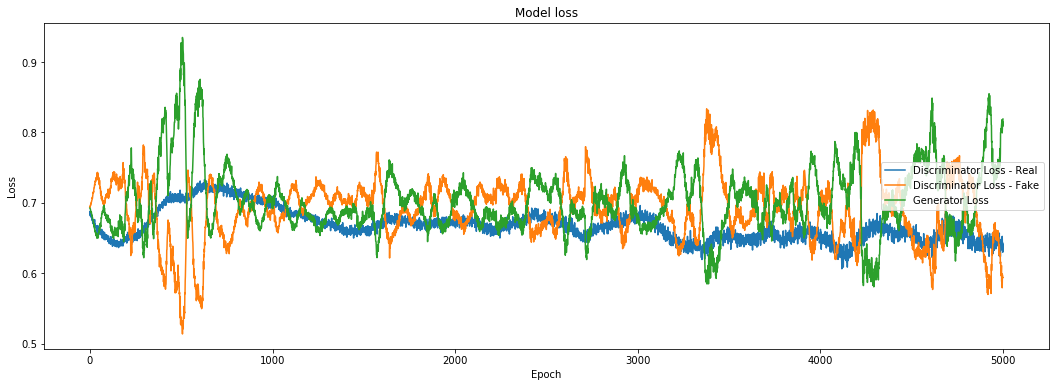

In [43]:
# Model loss visualization.
plt.figure(figsize=(18, 6))
plt.plot(d_loss_real_list)
plt.plot(d_loss_fake_list)
plt.plot(g_loss_list)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator Loss - Real', 'Discriminator Loss - Fake', 'Generator Loss'], loc='center right')
plt.show()

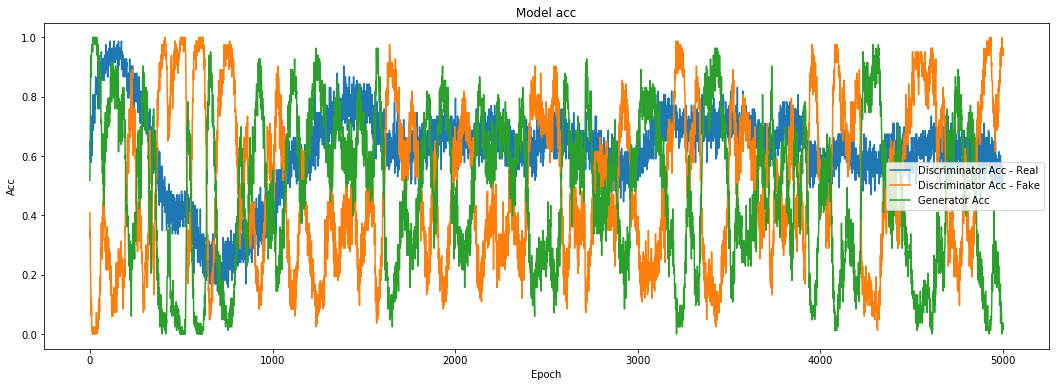

In [44]:
# Model acc visualization.
plt.figure(figsize=(18, 6))
plt.plot(d_acc_real_list)
plt.plot(d_acc_fake_list)
plt.plot(g_acc_list)
plt.title('Model acc')
plt.ylabel('Acc')
plt.xlabel('Epoch')
plt.legend(['Discriminator Acc - Real', 'Discriminator Acc - Fake', 'Generator Acc'], loc='center right')
plt.show()

## t-SNE를 통한 시각화 (원본 소수 클래스, 생성된 소수 클래스)

(166, 2)


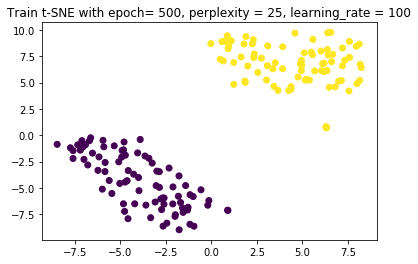

(166, 2)


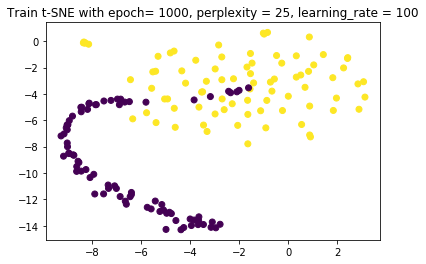

(166, 2)


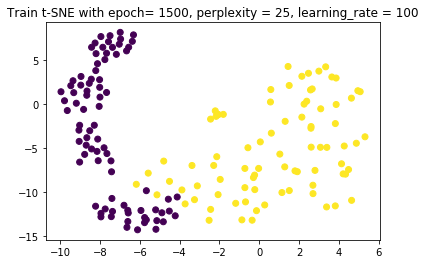

(166, 2)


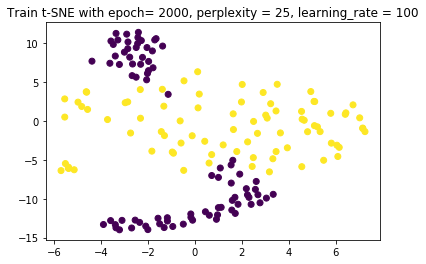

(166, 2)


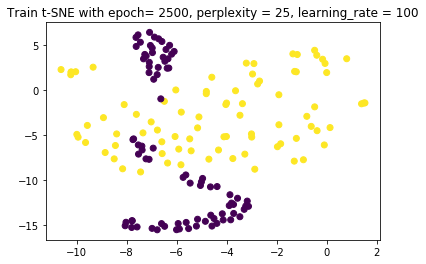

(166, 2)


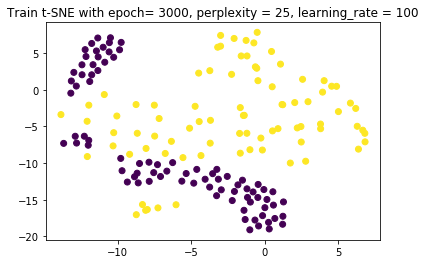

(166, 2)


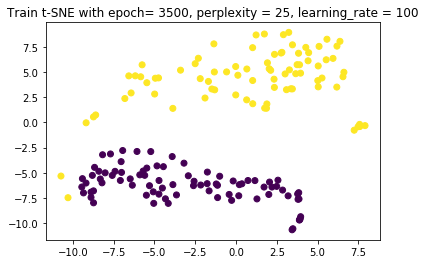

(166, 2)


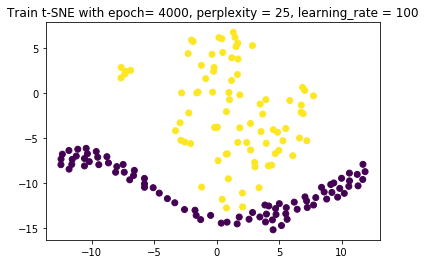

(166, 2)


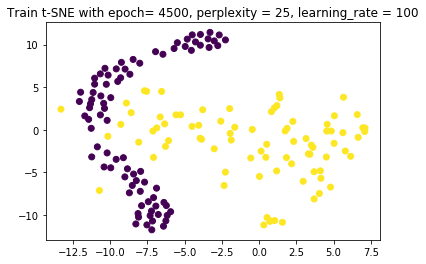

(166, 2)


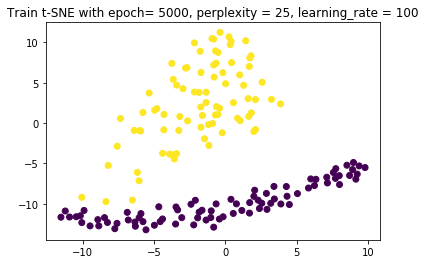

In [45]:
# t-SNE를 통해 원본 소수 클래스와 생성된 소수 클래스에 대하여 시각화를 수행.
# t-SNE를 통해 시각화를 수행하였을 때, 겹쳐보이는 모습이 나타난다면, GAN을 통한 소수 클래스 generate가 잘 수행되었다고 판단할 수 있을 것이라고 생각함.
epochs_list = [x for x in range(100, 5000+1) if x % 500 ==0]

for epoch in epochs_list :
    
    gan_generated_data = pd.read_csv("../../mypydata/generatedData/gan_generated_data_epoch_%d.csv" % epoch)
    gan_generated_data[590] = 0
    
    combined_real_fake = np.concatenate((df_minority_class, gan_generated_data), axis=0)
    combined_real_fake = pd.DataFrame(data = combined_real_fake)
    
    features = combined_real_fake.values[:, 0:gan_generated_data.shape[1]-1]
    label = combined_real_fake.values[:, gan_generated_data.shape[1]-1]
    
    perplexity_list = [25] # 모든 파일에서 25으로 고정할 것.
    learning_rate_list = [100] # 모든 파일에서 100으로 고정할 것.

    for perplexity in perplexity_list :
    
        for learning_rate in learning_rate_list :
        
            model = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, random_state=seed) 
            features_embedded  = model.fit_transform(features)
            print(features_embedded.shape)
        
            # 2차원 형태로 차원 축소된다.
            xs = features_embedded[:,0]
            ys = features_embedded[:,1]
            title_tr = 'Train t-SNE with epoch= {}, perplexity = {}, learning_rate = {}'.format(epoch, perplexity, learning_rate)
            plt.scatter(xs, ys, c=label)
            plt.title(title_tr)
            plt.show()